In [ ]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import numpy as np
import matplotlib.pyplot as plt


# Check PyTorch version
torch.__version__


'2.1.0+cu121'

In [ ]:
what_were_covering = {1: "data (prepare and load)",
                      2: "build model",
                      3: "fitting the model to data (training)",
                      4: "making predictions and evaluting a model (interface)",
                      5: "saving and loading a model",
                      6: "putting it all together"}

## 1.Data (prepare and load)

Machine learning is a game of two parts:
1. Get data into a numerical representation.
2. Build a model to learn patterns in that numerical representation.

To shawcase this, lets create some known data using the linear regression formula.

We'll use a a linear regression formula to make a straight line with known **parameters**



In [ ]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step). unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [ ]:
len(X), len(y)

(50, 50)

## Splitting data into training and test sets (one of the most important concepts in machine learning in general)

Let's create a training and test sets with our data.

In [ ]:
# Create a train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:] , y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

How might we better visualing our data?

This is where the data explorer's motto comes in!

"Visualize, visualize, visualize..."

In [ ]:
def plot_predictions(train_data = X_train,
                     train_labels = y_train,
                     test_data = X_test,
                     test_labels = y_test,
                     predictions = None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10,7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label = "Training data")

  # Plot test data in blue
  plt.scatter(test_data, test_labels, c="g", s=4, label = "Testing data")

  # Are there predictions?
  if predictions is not None:
    # Plot the predictions if they exists
    plt.scatter(test_data, predictions, c="r", s=4, label = "Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

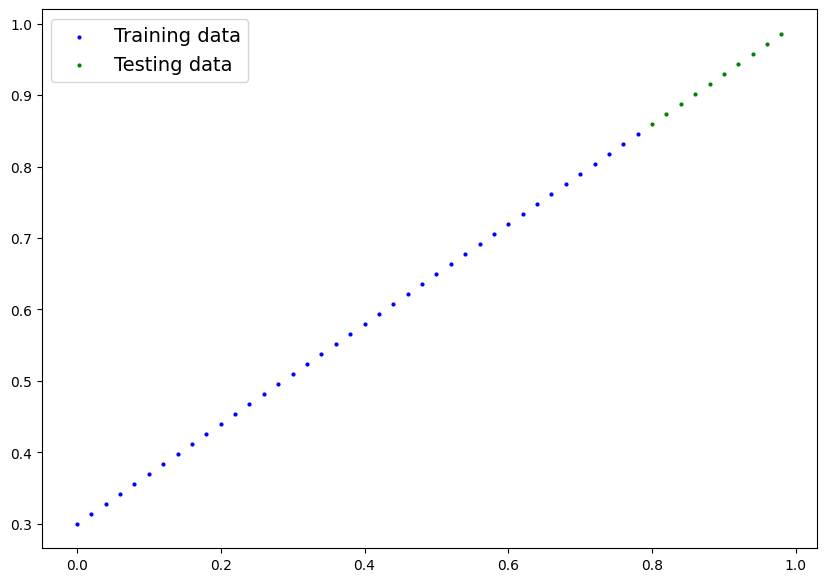

In [ ]:
plot_predictions()

## 2. Build model



In [ ]:
# Create linear regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch inherhits from nn.Module
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
    self.bais = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))

  # Forward method to define the computation in the model
  def forward(self, X: torch.Tensor) -> torch.Tensor:
    return self.weights * X + self.bais




Two main algorithms:
1. Gradient descent
2. Backpropagation

In [ ]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module)
model_0 = LinearRegressionModel()
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [ ]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bais', tensor([0.1288]))])

In [ ]:
weight, bias

(0.7, 0.3)

### Making prediction using `torch.inference_mode()`

To check our model's predicitive power, let's see how well it predicts `y_test` based on `x_test`.

When we pass data through the `forword()` method

In [ ]:
# Make prediction with model
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [ ]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

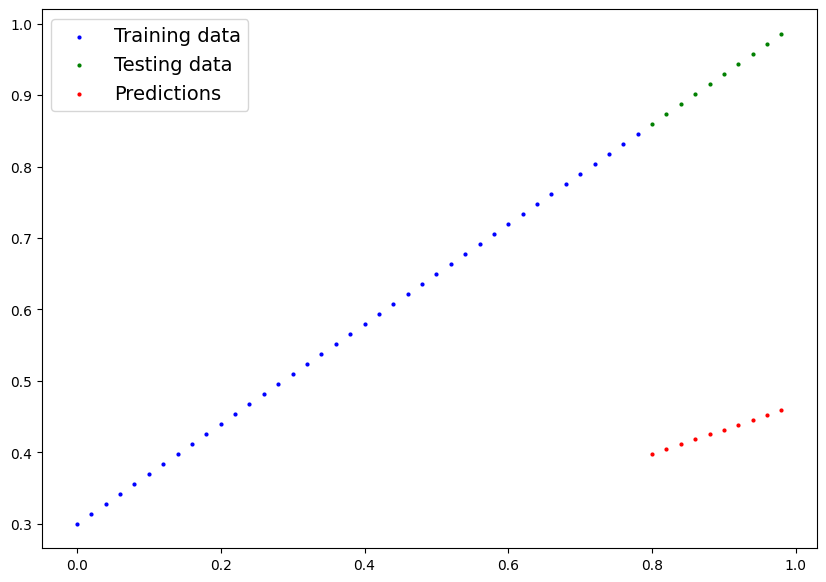

In [ ]:
plot_predictions(predictions=y_preds)

In [ ]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),lr=0.001) #learning rate

### Building a training loop (and a testing loop) in PyTorch

A couple of thing we need in a training loop:


1.   Loop through the data
2.   Forward pass (this involves data moving our model's `forward()` function) to make predictions on data - also called forward propagation.
3.   Calculate the loss (compare forward pass predictions to ground truth labels)
4.   Optimizer zero grad
5.   Loss backward - move backwards through the netwaork to calculate the gradients of each of the parameters of our model with respect to the loss
6.   Optimizer step - use the ptimizer to adjust our model's params to try and improve the loss.



In [ ]:
# An epoch is one loop through the data
epochs = 2000

# Track different values
epoch_count = []
loss_values = []
test_loss_values = []

# 1. Loop through the data
for epoch in range(epochs):
  model_0.train() # train mode in PyTorch sets all params that require gradients to require gradients

  # 2. Forward pass
  y_pred = model_0(X_train)

  # 3. Calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 4. Optimizer zero grad
  optimizer.zero_grad()

  # 5. Perform backpropagation on the loss with respect to the params of the model
  loss.backward()

  # 6. Step the optimizer (perform gradient descent)
  optimizer.step()

  ### Testing
  model_0.eval() # turns off gradient tracking
  with torch.inference_mode():
    # 1. Do the forward pass
    test_pred = model_0(X_test)

    # 2. Calculate the loss
    test_loss = loss_fn(test_pred, y_test)
  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

  # print(model_0.state_dict())


Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.4931890368461609
Epoch: 10 | Loss: 0.3013603389263153 | Test loss: 0.4797181189060211
Epoch: 20 | Loss: 0.28983938694000244 | Test loss: 0.4662471413612366
Epoch: 30 | Loss: 0.2783183455467224 | Test loss: 0.4527761936187744
Epoch: 40 | Loss: 0.26679736375808716 | Test loss: 0.43930521607398987
Epoch: 50 | Loss: 0.2552763819694519 | Test loss: 0.4258342385292053
Epoch: 60 | Loss: 0.24375538527965546 | Test loss: 0.41236335039138794
Epoch: 70 | Loss: 0.232234388589859 | Test loss: 0.398892343044281
Epoch: 80 | Loss: 0.22071340680122375 | Test loss: 0.38542139530181885
Epoch: 90 | Loss: 0.2091923952102661 | Test loss: 0.3719504475593567
Epoch: 100 | Loss: 0.19767141342163086 | Test loss: 0.35847947001457214
Epoch: 110 | Loss: 0.18615040183067322 | Test loss: 0.34500852227211
Epoch: 120 | Loss: 0.17462942004203796 | Test loss: 0.33153754472732544
Epoch: 130 | Loss: 0.16310855746269226 | Test loss: 0.3180667459964752
Epoch: 140 | Loss: 0.

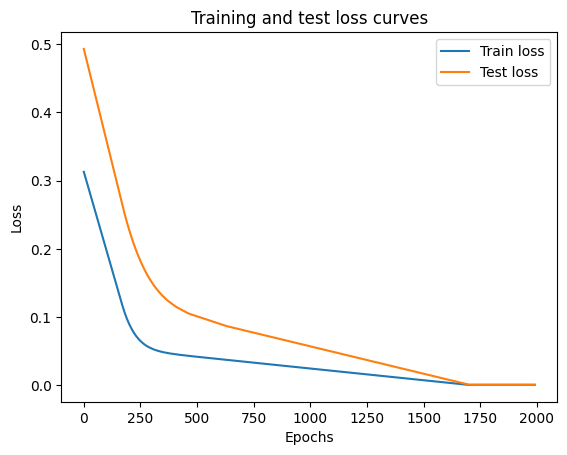

In [ ]:
# Plot the loss curves
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label= "Train loss")
plt.plot(epoch_count, test_loss_values, label= "Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [ ]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6994])), ('bais', tensor([0.2998]))])

In [ ]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

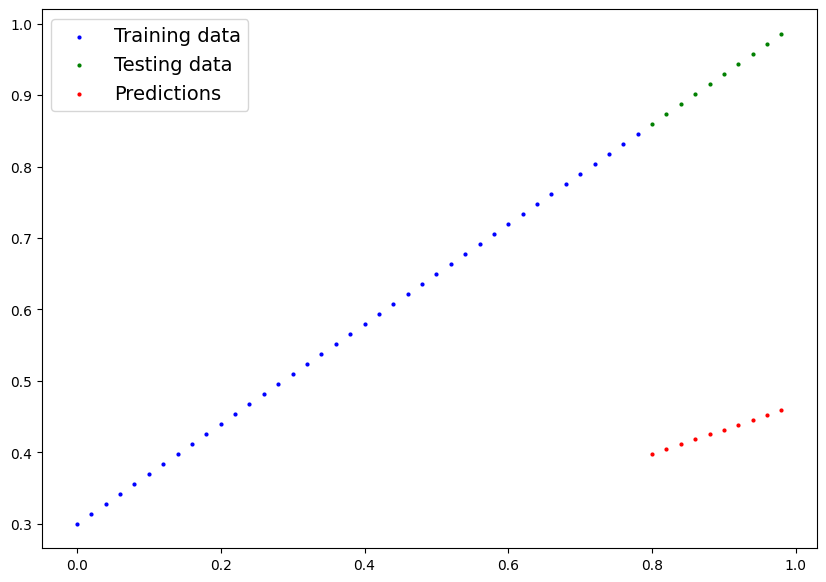

In [ ]:
plot_predictions(predictions=y_preds)

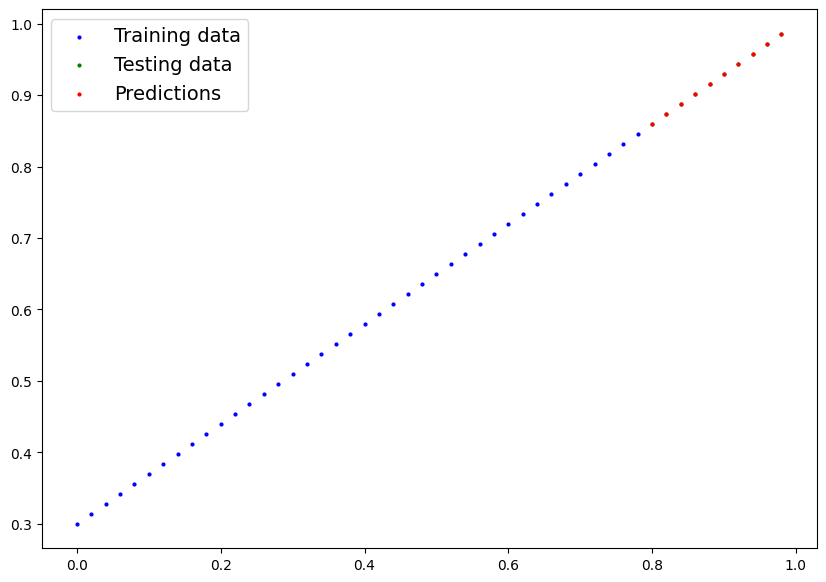

In [ ]:
plot_predictions(predictions=y_preds_new)

### Saving a model in PyTorch

1. `torch.save()` - allows you save a PyTorch object in Python's pickle format
2.  `torch.load()` - allows you load a PyTorch object in Python's pickle format.
3. `torch.nn.Module.load_state_dict()` - this allows to load a model's saved state dictionary

In [ ]:
# Saving our PyTorch model
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
MODEL_SAVE_PATH

# 3. Save the model's state dict
print(f"Saving model to : {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

Saving model to : models/01_pytorch_workflow_model_0.pth


In [ ]:
## Loading
loaded_model_0 = LinearRegressionModel()

print(f"Before loading: {loaded_model_0.state_dict()}")

loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

print(f"After loading: {loaded_model_0.state_dict()}")

Before loading: OrderedDict([('weights', tensor([2.2082])), ('bais', tensor([-0.6380]))])
After loading: OrderedDict([('weights', tensor([0.6994])), ('bais', tensor([0.2998]))])


In [ ]:
class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    # Use nn.Linear() for crearting the model params
    self.linear_layer = nn.Linear(in_features=1, out_features=1)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

# set manual seed
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()

model_1, model_1.state_dict()

(LinearRegressionModel2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))